In [16]:
import tensorflow as tf
from pathlib import Path
import sys
from tqdm import tqdm

helper_path = "../../"
import numpy as np

sys.path.append(helper_path)

from helper import load_image_as_yuv422_original, get_postgres_cursor, get_labelstudio_client

## Get number of balls in dataset

In [20]:
select_statement = f"""        
SELECT ls_project_bottom
FROM robot_logs
WHERE bucket_bottom IS NOT NULL
AND ls_project_bottom IS NOT NULL
AND bottom_validated = true
"""
cur = get_postgres_cursor()

cur.execute(select_statement)
rtn_val = cur.fetchall()
data = [x[0] for x in rtn_val]

ls = get_labelstudio_client()
ball_count = 0
for ls_project_id in data:
    ls_project = ls.get_project(id=ls_project_id)
    labeled_tasks = ls_project.get_labeled_tasks()

    for task in labeled_tasks:
        for annotation in task["annotations"]:
            for result in annotation["result"]:
                if result["type"] != "rectanglelabels":
                    continue

                actual_label = result["value"]["rectanglelabels"][0]

                if actual_label == "ball":
                    ball_count += 1

print(f"Ball Count: {ball_count}")

# 3064 in whole dataset
# segmentation: 2.551
# old 1.358

Ball Count: 3064


In [7]:
ball_images = list(Path(f"./datasets/ball/").glob("**/*.png"))
other_images = list(Path(f"./datasets/other/").glob("**/*.png"))
penalty_images = list(Path(f"./datasets/penalty/").glob("**/*.png"))
robot_images = list(Path(f"./datasets/robot/").glob("**/*.png"))

In [38]:
false_positiv = 0
image_list_false_positive = []
for image_path in robot_images:
    image_yuv = load_image_as_yuv422_original(str(image_path))
    image_yuv = image_yuv.reshape(16, 16, 2)
    image_y = image_yuv[..., 0]
    image_y = np.array(image_y, dtype=np.uint8).reshape(16, 16, 1)
    image_y = image_y / 255.0

    image_input = np.expand_dims(image_y, axis=0)
    model = tf.keras.models.load_model("tiny_classifier_segmentation_output_v1.keras")
    result = model.predict(image_input, verbose=0)
    if result > 0.8:
        false_positiv += 1
        print(image_path, result)
        image_list_false_positive.append(image_path)

print(false_positiv)

datasets/robot/rqeruwggyqijgzvnxvimav_0019330_0_intersect_0.9969.png [[0.9753296]]
datasets/robot/ltcegottjrksgvvxwvrvct_0032139_0_intersect_1.0000.png [[0.8394109]]
datasets/robot/tmuczxmbyfmksktfxaavlu_0027773_0_intersect_1.0000.png [[0.80695754]]
datasets/robot/qpyjuubwhbqptfpysmnqdk_0029416_0_intersect_1.0000.png [[0.8160008]]
datasets/robot/qpyjuubwhbqptfpysmnqdk_0023945_0_intersect_1.0000.png [[0.8084535]]
5


In [35]:
false_negative = 0
image_list_false_negative = []
for image_path in ball_images:
    image_yuv = load_image_as_yuv422_original(str(image_path))
    image_yuv = image_yuv.reshape(16, 16, 2)
    image_y = image_yuv[..., 0]
    image_y = np.array(image_y, dtype=np.uint8).reshape(16, 16, 1)
    image_y = image_y / 255.0

    image_input = np.expand_dims(image_y, axis=0)
    model = tf.keras.models.load_model("tiny_classifier_segmentation_output_v1.keras")
    result = model.predict(image_input, verbose=0)
    if result < 0.9:
        false_negative += 1
        image_list_false_negative.append(image_path)
        # print(image_path, result)

print(false_negative)

datasets/ball/dwvgrzygynvxkhiddootwr_0010397_0_intersect_0.7071.png [[0.80762696]]
datasets/ball/lnfjmcgugfvtzurjwdtail_0017108_0_intersect_0.3693.png [[0.24879736]]
datasets/ball/sdsowswaennisxvfgiqozw_0012703_0_intersect_0.8977.png [[0.88297707]]
datasets/ball/seoypobhoabinvurfcmbun_0007262_0_intersect_0.8019.png [[0.89385206]]
datasets/ball/cfcwmrilyoftrwgrhejwlg_0022484_0_intersect_0.2398.png [[0.88841176]]
datasets/ball/xkcedpnsgksqxypznuinoq_0035975_0_intersect_1.0000.png [[0.87204725]]
datasets/ball/egmjbdiaygyqcbjcigwbua_0043113_0_intersect_0.7028.png [[0.18388867]]
datasets/ball/cfcwmrilyoftrwgrhejwlg_0022893_1_intersect_0.5621.png [[0.7785069]]
datasets/ball/neznxfnjaqlkbdbxbrotso_0104207_0_intersect_0.3405.png [[0.6568272]]
datasets/ball/cfcwmrilyoftrwgrhejwlg_0022861_1_intersect_0.2604.png [[0.83310765]]
datasets/ball/rgtenltvyzlylbangfjhzf_0005879_0_intersect_0.7338.png [[0.8022415]]
datasets/ball/lnfjmcgugfvtzurjwdtail_0030894_0_intersect_0.9539.png [[0.8296812]]
datasets

In [39]:
import PIL.Image

false_negative = 0
image_list_false_negative = []
for image_path in ball_images:
    img = PIL.Image.open(image_path)
    p_min_x = int(img.info["p_min_x"]) / 640
    p_min_y = int(img.info["p_min_y"]) / 480
    p_max_x = int(img.info["p_max_x"]) / 640
    p_max_y = int(img.info["p_max_y"]) / 480
    patch_meta = np.array([[p_min_x, p_min_y], [p_max_x, p_max_y]])
    patch_meta = np.tile(patch_meta, (8, 8))

    image_yuv = load_image_as_yuv422_original(str(image_path))
    image_yuv = image_yuv.reshape(16, 16, 2)
    image_y = np.array(image_yuv, dtype=np.uint8).reshape(16, 16, 2)
    image_y = image_y / 255.0
    image_y[:, :, 1] = patch_meta

    image_input = np.expand_dims(image_y, axis=0)
    model = tf.keras.models.load_model("tiny_classifier_segmentation_output_v3.keras")
    result = model.predict(image_input, verbose=0)
    if result < 0.9:
        false_negative += 1
        image_list_false_negative.append(image_path)
        # print(image_path, result)

print(false_negative)

46


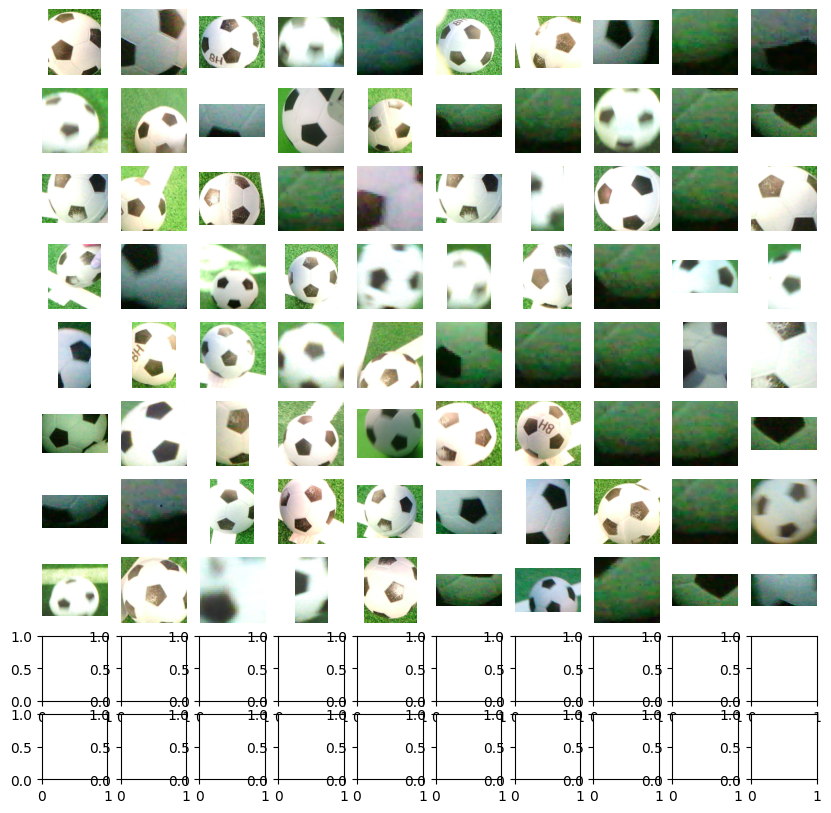

In [37]:
import matplotlib.pyplot as plt
import random
import cv2

length = len(image_list_false_negative)

fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(length):
    row = int(i / 10)
    col = i % 10
    image_yuv = cv2.imread(str(image_list_false_negative[i]))

    ax[row, col].imshow(image_yuv, cmap="gray")
    ax[row, col].axis("off")

In [28]:
print(int(31 / 10))

3


Evaluate original model on original patch data

In [40]:
ball_images = list(Path(f"./datasets_old/ball/").glob("**/*.png"))

In [41]:
import PIL.Image

false_negative = 0
image_list_false_negative = []
for image_path in ball_images:

    image_yuv = load_image_as_yuv422_original(str(image_path))
    image_yuv = image_yuv.reshape(16, 16, 2)
    image_y = np.array(image_yuv, dtype=np.uint8).reshape(16, 16, 2)
    image_y = image_y[:, :, 0]
    image_y = image_y / 255.0

    image_input = np.expand_dims(image_y, axis=0)
    model = tf.keras.models.load_model("tiny_classifier_segmentation_output_v3_original_mean.keras")
    # TODO for those kinds of experiments we need to subtract the mean or we use the datasets
    result = model.predict(image_input, verbose=0)
    if result < 0.9:
        false_negative += 1
        image_list_false_negative.append(image_path)
        # print(image_path, result)

print(false_negative)

120
